In [ ]:
# Importing relevant models
import pandas 
import numpy as np
import gensim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.sparse import dok_matrix
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding,GlobalMaxPool1D,Flatten, Bidirectional
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
import collections, numpy
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [ ]:
# Mount the drive to your google colaboratory (can be skipped if not working in google collab)
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Set working directory to path where the X_train and Y_train data is stored.
%cd drive/My Drive/Project DL

/content/drive/My Drive/Project DL


In [ ]:
# List of all files in the current working directory
%ls 

'Deep Learning Project.ipynb'   Tokenizer_test.ipynb   X_data.txt
 predictions.txt                Untitled0.ipynb        X_test.txt
 Project_DL_v1.ipynb            Untitled1.ipynb        y_data.txt


In [ ]:
# Load the data and put all sentences in a list
with open('X_data.txt') as X_train:
    mylist = [line.rstrip('\n') for line in X_train]

X_train = mylist
print(X_train[0:5])

['The German economy contracted 5 and EU trade much more so', 'From tomorrow visa liberalisation will come into effect for the remaining countries so that there is full reciprocity', 'All in all although it has been long it has been well worthwhile', 'However while the current developments are certainly heading in the right direction we are still not entirely happy with them for two reasons', 'He is wise to recommend that Parliament gives its assent to the position that the Council has adopted']


In [ ]:
# Replace all uppercase letters with lowercase letters
X_train = [x.lower() for x in X_train]
print(X_train[0])

the german economy contracted 5 and eu trade much more so


In [ ]:
# Load the data and put all labels in a list
with open('y_data.txt') as y_train:
    mylist = [line.rstrip('\n') for line in y_train]

y_train = mylist

# Transform the labels to an array
y_train = np.asarray(y_train).astype('float32')

nb_sentences = len(X_train)

print(y_train[0:5])

[0. 0. 0. 1. 0.]


In [ ]:
# Create tokenizer object
tokenizer  = Tokenizer()

# Train the Tokenizer to the texts
tokenizer.fit_on_texts(X_train)

# Convert list of strings into list of lists of integers
X_train_tokenized = tokenizer.texts_to_sequences(X_train)

In [ ]:
# Example of a sentenze transformed into a list of integers
print(X_train[0])
print(X_train_tokenized[0])

the german economy contracted 5 and eu trade much more so
[1, 1341, 446, 14433, 688, 4, 72, 195, 163, 54, 65]


In [ ]:
# Mapping of indexes to words
idx_word = tokenizer.index_word

# Check if the words match with the indexed words
' '.join(idx_word[w] for w in X_train_tokenized[0][:5])

'the german economy contracted 5'

In [ ]:
# Check the length of the longest sentence for padding
longest_string = max(X_train_tokenized, key=len)
max_sentence = len(longest_string)
print(max_sentence)

201


In [ ]:
# Pad the sequences 
X_train_padded = pad_sequences(X_train_tokenized, padding='post')
print(X_train_padded[0:5])

# The length of a single sequence
print(len(X_train_padded[0]))

# The shape of the data
print(X_train_padded.shape)
print(type(X_train_padded))


[[   1 1341  446 ...    0    0    0]
 [  36  682 2121 ...    0    0    0]
 [  30    5   30 ...    0    0    0]
 [ 103  268    1 ...    0    0    0]
 [ 127    8 3452 ...    0    0    0]]
201
(188775, 201)
<class 'numpy.ndarray'>


In [ ]:
# The amount of words in the vocabulary and the amount of rows in the X_train data
num_words = len(idx_word)+1 # +1 since the zero'th index has no value
num_sentences = len(X_train_padded)
print(num_words)
print(num_sentences)

38058
188775


In [ ]:
# Train test split with stratification to make sure output classes (labels) are equally distributed in test and valid set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_padded, y_train,
                                                    stratify=y_train, 
                                                    test_size=0.2)


In [ ]:
# The data is equally distributed among classes over the training and validation sets 
print(collections.Counter(y_valid)) 
print(collections.Counter(y_train))

Counter({1.0: 18886, 0.0: 18869})
Counter({1.0: 75545, 0.0: 75475})


In [ ]:
# Final model
model = Sequential()

model.add(Embedding(num_words, 32, input_length=max_sentence))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

print(model.summary())



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 201, 32)           1217856   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49664     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,267,649
Trainable params: 1,267,649
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/5
61/61 [==============================] - 11s 180ms/step - loss: 0.6531 - accuracy: 0.6091 - val_loss: 0.5659 - val_accuracy: 0.7064
Epoch 2/5
61/61 [==============================] - 10s 169ms/step - loss: 0.5043 - accuracy: 0.7490 - val_loss: 0.5002 - val_accuracy: 0.7495
Epoch 3/5
61/61 [==============================] - 10s 169ms/step - loss: 0.4514 - accuracy: 0.7840 - val_loss: 0.4961 - val_accuracy: 0.7523
Epoch 4/5
61/61 [==============================] - 10s 170ms/step - loss: 0.4266 - accuracy: 0.7988 - val_loss: 0.4965 - val_accuracy: 0.7550
Epoch 5/5
61/61 [==============================] - 10s 171ms/step - loss: 0.4088 - accuracy: 0.8092 - val_loss: 0.4975 - val_accuracy: 0.7558


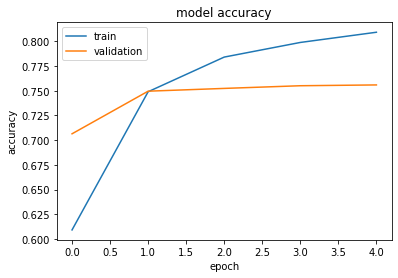

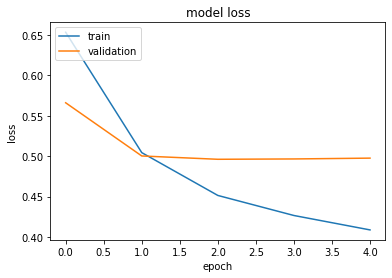

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=5, batch_size=2500)

#### Summarize history accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

### Summarize for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

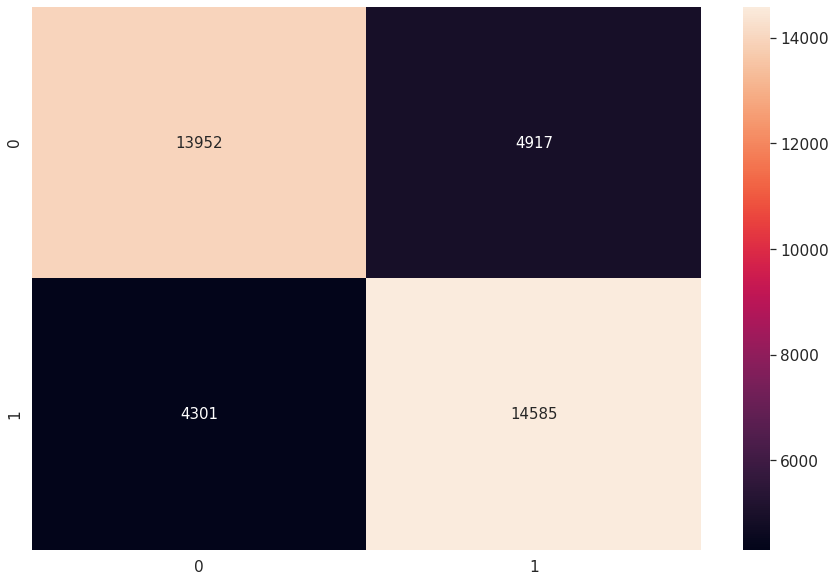

In [ ]:
# Create a confusion matrix
y_pred = (model.predict(X_valid).ravel()>0.5)+0

# Change datatype to list so a confusion matrix can be made
cm_y_pred = list(y_pred)
cm_y_valid = list(y_valid)

cm = confusion_matrix(cm_y_valid, cm_y_pred)
df_cm = pd.DataFrame(cm, range(2), range(2))
plt.figure(figsize=(15,10))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15}, fmt = 'g')

In [ ]:
# Function to open and clean the test dataset
def pre_processing_data(filename):
  test_data = open(filename)
  test_data = [line.rstrip('\n') for line in test_data]
  test_data = [x.lower() for x in test_data]
  test_data = tokenizer.texts_to_sequences(test_data)
  test_data = pad_sequences(test_data, maxlen = max_sentence,padding='post')
  return test_data

In [ ]:
# Applying the function to X_test
pre_processing_data('X_test.txt')

array([[ 127, 1159,    9, ...,    0,    0,    0],
       [ 700,  241,  137, ...,    0,    0,    0],
       [  10,  121,   11, ...,    0,    0,    0],
       ...,
       [ 660, 2745, 4438, ...,    0,    0,    0],
       [  28,    1,  167, ...,    0,    0,    0],
       [  13,    1, 1132, ...,    0,    0,    0]], dtype=int32)

In [ ]:
# Predicting the labels for X_test
predictions = model.predict_classes(pre_processing_data('X_test.txt'))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
# Saving the predictions to a textfile
numpy.savetxt('predictions.txt', predictions,fmt = '%1.1d')